In [1]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, schedules
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard,ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.util import crop
from skimage.io import imsave, imread
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import disk
from skimage.io import imsave
import time


sys.path.append('../src')
import unet7

In [2]:
#code to check for GPU
import tensorflow as tf

print("Num CPUs Available: ", len(tf.compat.v1.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.compat.v1.config.list_physical_devices('GPU')))

Num CPUs Available:  1
Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15898326784361304270
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16149970944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6021264344018940791
physical_device_desc: "device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 6.0"
xla_global_id: 416903419
]


2022-10-27 11:09:50.925422: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 11:10:02.676355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 6.0


In [4]:
import keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

2022-10-27 11:22:45.138729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 6.0


In [5]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
epochs = 100 #100 1001
batch_size = 32
smooth = 1.
start_lr = 1e-4
target_width = 256
target_height = 256

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_rows / target_height

In [7]:
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(
    project="mlid/DeepUTI",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0Y2JmNWIzMS1hYmMyLTQ2ODUtODVmNy02MWJiNzBlODQ0M2MifQ==",  
)

https://app.neptune.ai/mlid/DeepUTI/e/DUTI-3
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/home/de29/.conda/envs/deeputi/lib/python3.10/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/de29/.conda/envs/deeputi/lib/python3.10/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


In [8]:
parameters = {
    "img_cols": 1392,
    "img_rows": 1040,
    "epochs": 100,
    "batch_size": 32,
    "smooth": 1.,
    "start_lr": 1e-4,
    "target_width": 256,
    "target_height": 256,
    "upscale_factor_width": img_cols/ target_width,
    "upscale_factor_height": img_rows/ target_height
}

run["model/parameters"] = parameters

In [6]:
def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def read_imgs(dir, img_rows, img_cols):
    images = [f for f in os.listdir(dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        img = imread(os.path.join(dir, img), as_gray=True)
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
    return imgs

def test_model(model, x, y_true, log_dir):
    y_true = y_true[0]
    y_pred = model.predict(x)
    y_pred = y_pred[0]
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.squeeze(y_pred))

    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    plt.imshow(np.squeeze(y_true))

    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.png'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()

In [7]:
runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = os.path.join('..','data')
log_dir = os.path.join(model_dir, 'Practice','logs',"{}".format(runningTime))
checkDir(log_dir)

In [11]:
# Add additional parameters
run["model/parameters/runningTime"] = runningTime
run["model/parameters/model_dir"] = model_dir
run["model/parameters/log_dir"] = log_dir

# Update parameters. For example, after triggering early stopping
# run["model/parameters/n_epochs"] = epoch

In [7]:
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [10]:
# Training


tensorboard = TensorBoard(log_dir=os.path.join(model_dir,"{}".format(runningTime)))
#tensorboard = TensorBoard(log_dir=log_dir)

# callbacksList = [tensorboard,NeptuneCallback(run=run)]
callbacksList = [tensorboard]

#model = unet7.get_unet(img_cols, img_rows)
model = unet7.Unet(target_width, target_width, nclasses=1)

#model.compile(optimizer=Adam(lr=5e-5), loss=unet7.dice_coef_loss, metrics=[unet7.dice_coef])
model.compile(optimizer=Adam(learning_rate=start_lr), loss=unet7.dice_loss, metrics=[unet7.dice_coeff])

model.summary()
#print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(model_dir,"{}".format(runningTime)+"\""))
print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir+"\""))

2022-10-12 10:04:45.516154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30990 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

In [8]:
def read_imgs_masks(img_dir, mask_dir, img_rows, img_cols,
                    target_width=img_cols, target_height=img_rows):
    images = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), target_height, target_width, 1), dtype=np.float64)
    masks = np.ndarray((len(images), target_height, target_width, 1), dtype=np.float64)
    for idx, img in enumerate(images):
        #print(idx)
        msk = img.replace('.tif', '_Simple Segmentation.tif')
        img = imread(os.path.join(img_dir, img), as_gray=True)
        # img = resize(img, (target_height, target_width))
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
        
        mask = imread(os.path.join(mask_dir, msk), as_gray=True)
        # mask = resize(mask, (target_height, target_width))
        mask = np.expand_dims(mask, axis=-1)
        masks[idx] = mask
    return imgs, masks

In [9]:
data = np.load('../data/030622_full_res_dataset_sample.npz')
training_imgs=data['training_imgs']
training_masks=data['training_masks']
test_imgs=data['test_imgs']
test_masks=data['test_masks']
del data

In [10]:
training_imgs.shape

(7, 1040, 1392, 1)

In [11]:
test_imgs.shape

(3, 1040, 1392, 1)

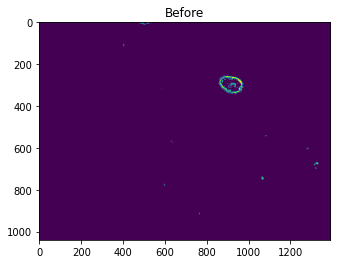

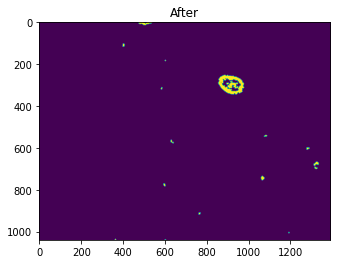

In [12]:
# improve the masks
test = training_masks[0]
plt.figure()
plt.title('Before')
plt.imshow(np.squeeze(test))
# plt.savefig(os.path.join(log_dir,"before_dilation.png"),bbox_inches='tight', dpi=300)
# run["model/samples/before_dilation"].upload(os.path.join(log_dir,"before_dilation.png"))

footprint = disk(3)
test = dilation(np.squeeze(test), footprint)


plt.figure()
plt.title('After')
plt.imshow(np.squeeze(test))
# plt.savefig(os.path.join(log_dir,"after_dilation.png"),bbox_inches='tight', dpi=300)
# run["model/samples/after_dilation"].upload(os.path.join(log_dir,"after_dilation.png"))

In [13]:
footprint = disk(3)

In [14]:
for i in range(training_masks.shape[0]):
    training_masks[i,:,:,0] = dilation(np.squeeze(training_masks[i,:,:,0]), footprint)

for i in range(test_masks.shape[0]):
    test_masks[i,:,:,0] = dilation(np.squeeze(test_masks[i,:,:,0]), footprint)

#### Combined mask and image as part of the same generator

In [22]:
from custom_keras_class_v2 import *

In [23]:
# Data augmentation of training images and masks

# sets defining what which transformations are applicable to which
image_tf = dict(samplewise_center=True,
                samplewise_std_normalization=True,
                vertical_flip=True,
                horizontal_flip=True,
                preprocessing_function=False,
                fill_mode=True,
                max_iter = True,
                thresh_obj_perc = True,
                target_width = True,
                target_height = True
                    
                )
mask_tf = dict(samplewise_center=False,
                samplewise_std_normalization=False,
                vertical_flip=True,
                horizontal_flip=True,
                preprocessing_function=True,
                fill_mode=True,
                max_iter = True,
                thresh_obj_perc = True,
                target_width = True,
                target_height = True
                    
                )

img_mask_gen_args = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=True,
                    horizontal_flip=True,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = 10,
                    thresh_obj_perc = 0.25,
                    target_width = 256,
                    target_height = 256,
                    image_aug_check = image_tf,
                    mask_aug_check = mask_tf
                     )

image_mask_datagen = customImageDataGenerator(**img_mask_gen_args)

seed = 123
image_mask_datagen.fit(training_imgs,image_tf,augment=True, seed=seed)
image_mask_generator = image_mask_datagen.flow(training_imgs,training_masks, batch_size=batch_size, seed=seed)

In [24]:
# Data augmentation of test images and masks

img_mask_gen_args_test = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=True,
                    horizontal_flip=True,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = 10,
                    thresh_obj_perc = 0.25,
                    target_width = 256,
                    target_height = 256,
                    image_aug_check = image_tf,
                    mask_aug_check = mask_tf
                     )

image_mask_datagen_test = customImageDataGenerator(**img_mask_gen_args_test)

seed = 123
image_mask_datagen_test.fit(test_imgs,image_tf, augment=True, seed=seed)
image_mask_generator_test = image_mask_datagen_test.flow(test_imgs,test_masks, batch_size=batch_size, seed=seed)

In [25]:
print(tf.shape(image_mask_generator.next()))

tf.Tensor([  2   7 256 256   1], shape=(5,), dtype=int32)


In [26]:
print(tf.shape(image_mask_generator_test.next()))

tf.Tensor([  2   3 256 256   1], shape=(5,), dtype=int32)


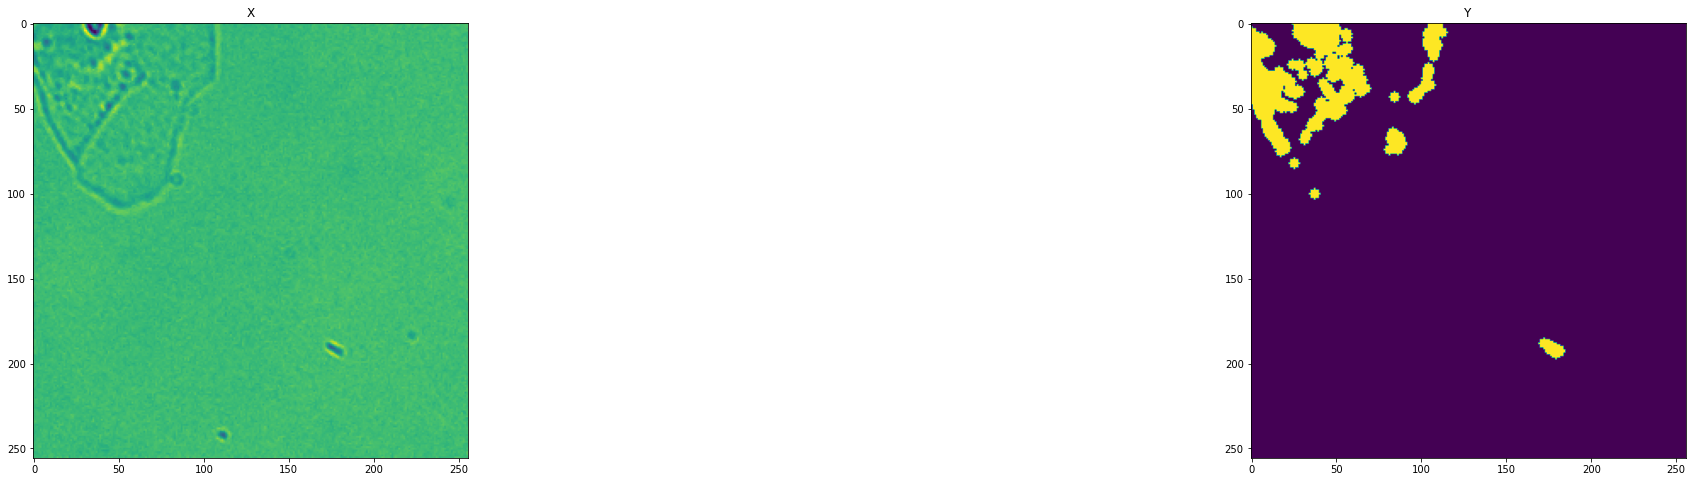

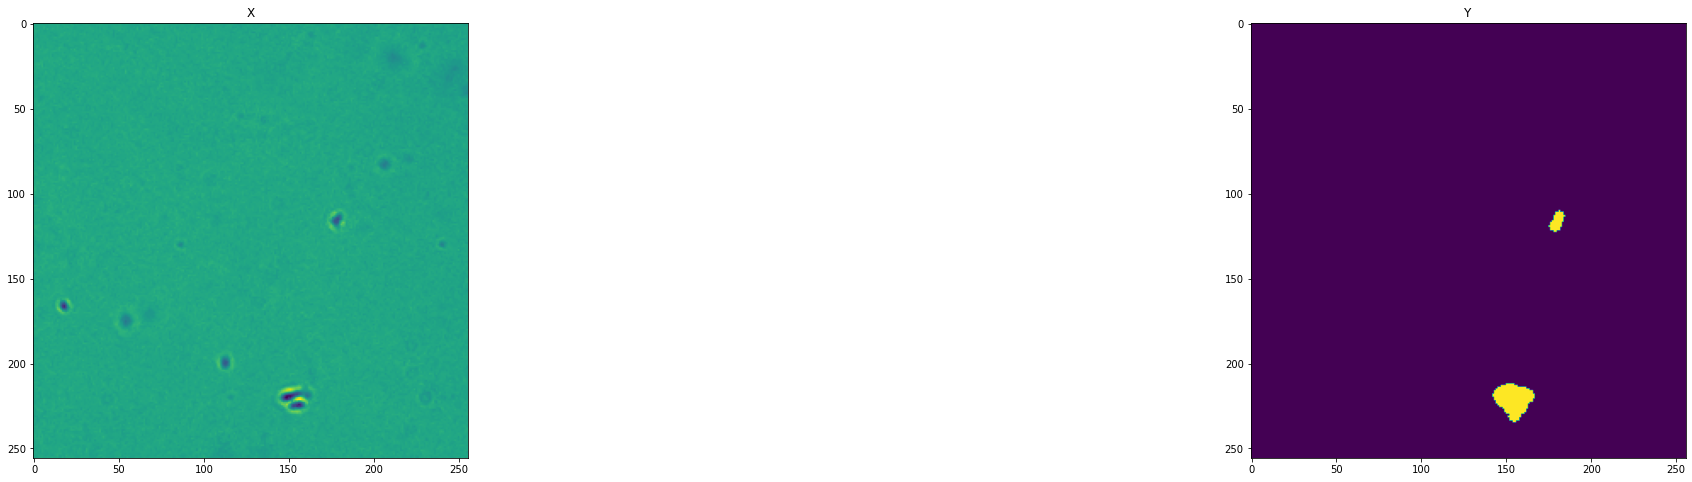

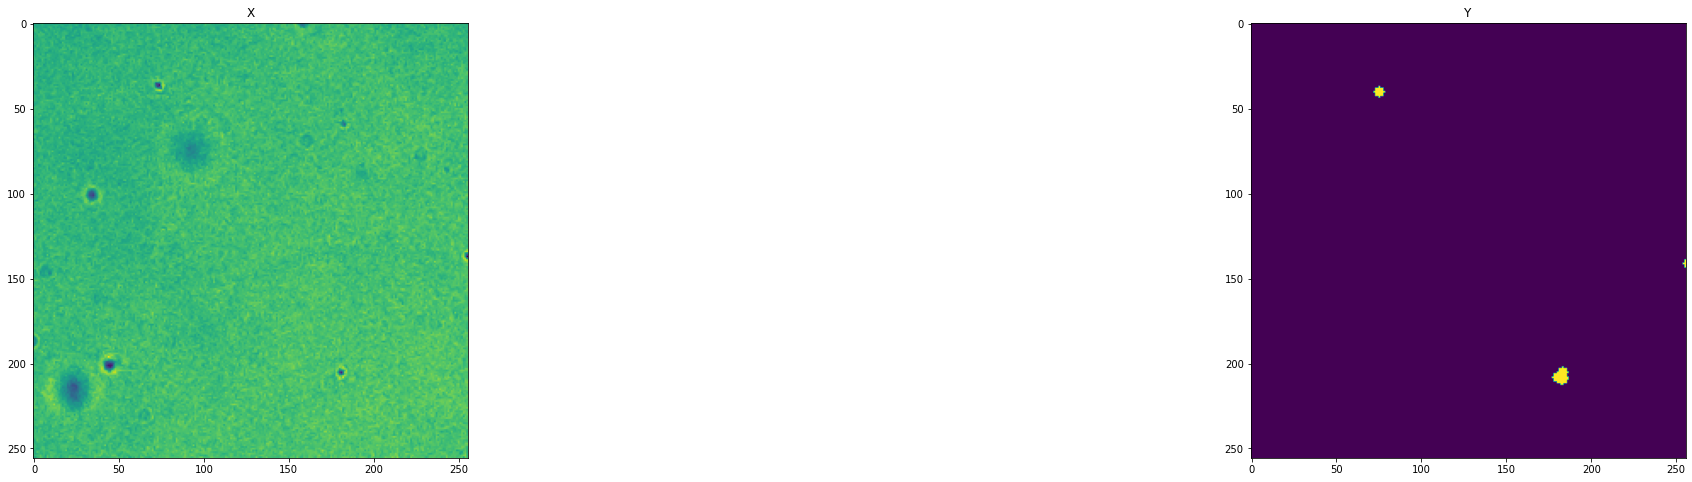

In [29]:
result = image_mask_generator_test.next()
test_img_exmp, test_mask_exmp = result[0], result[1]

for i in range(test_img_exmp.shape[0]):
    x = test_img_exmp[i]
    y = test_mask_exmp[i]
    plt.figure(figsize=(40,8))
    plt.subplot(1, 2, 1)
    plt.title('X')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 2, 2)
    plt.title('Y')
    plt.imshow(np.squeeze(y))

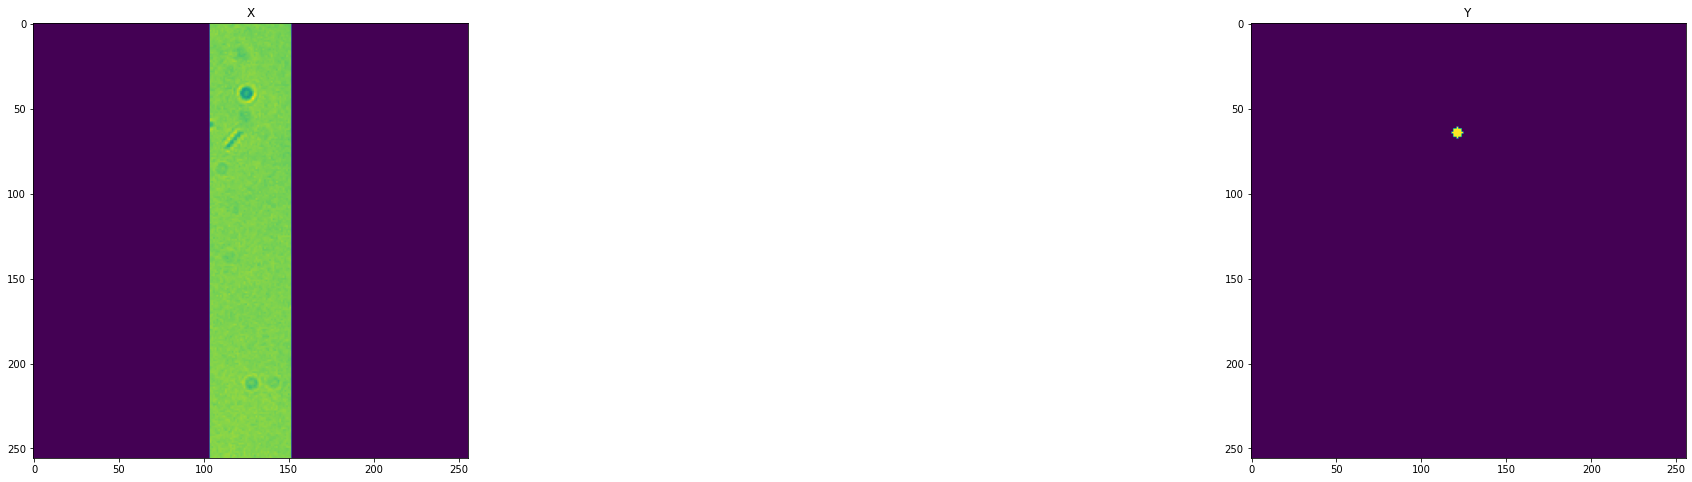

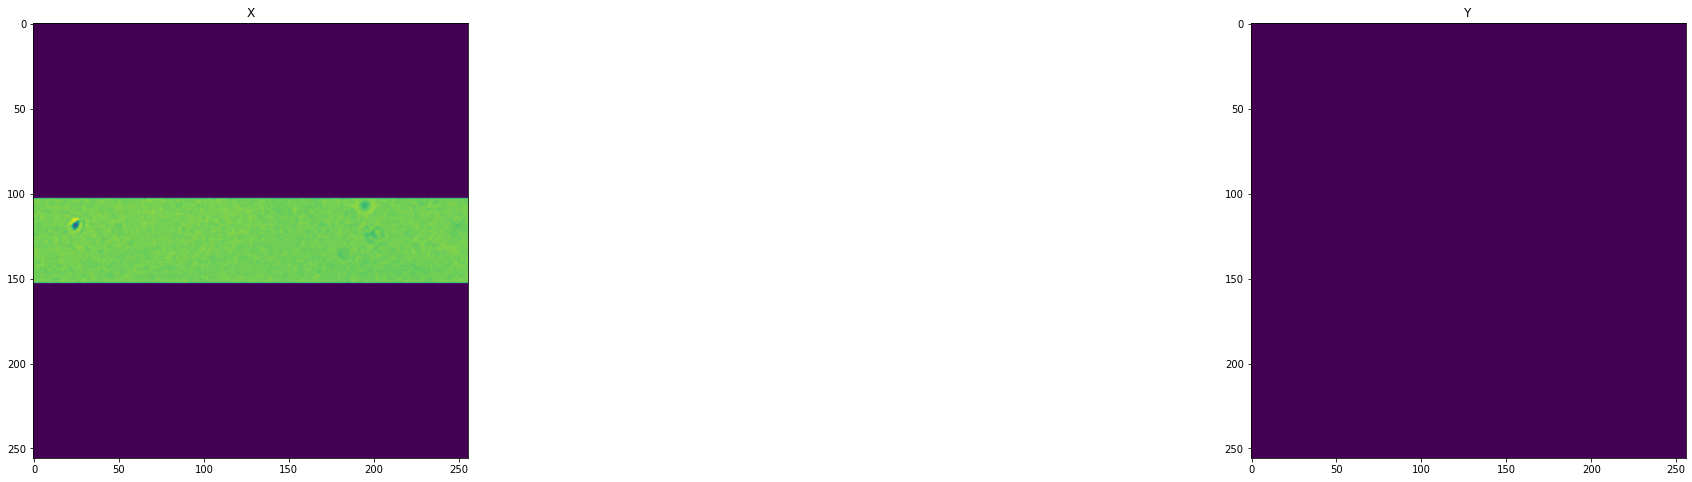

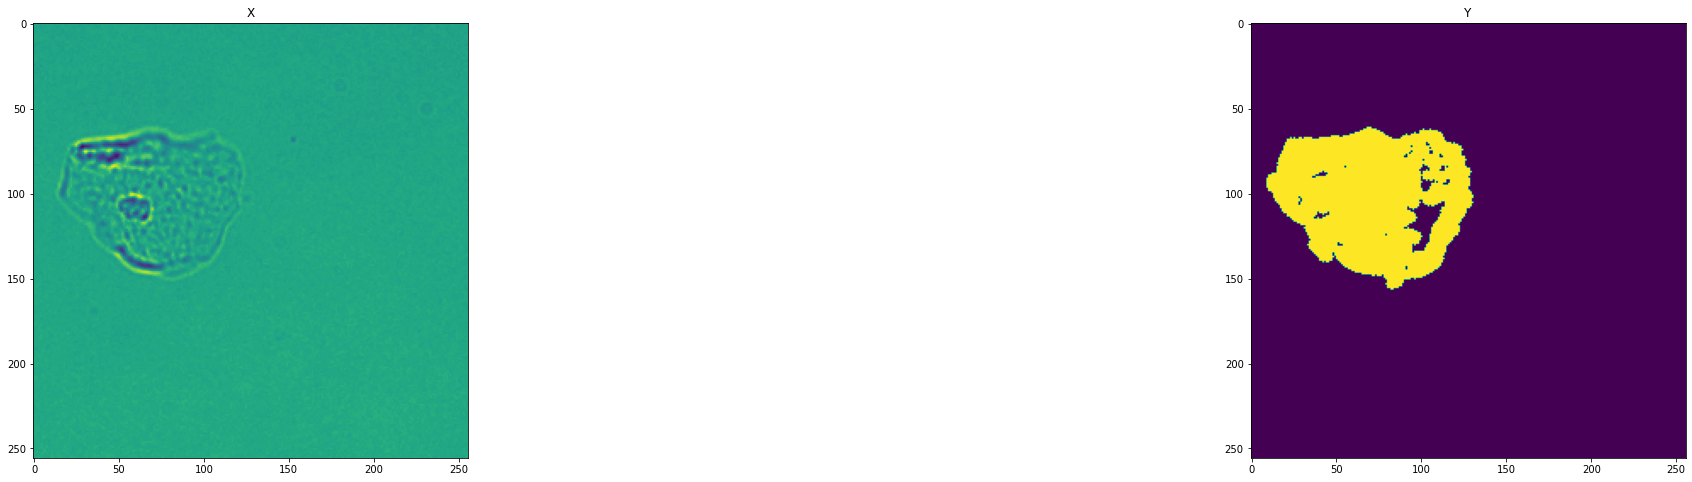

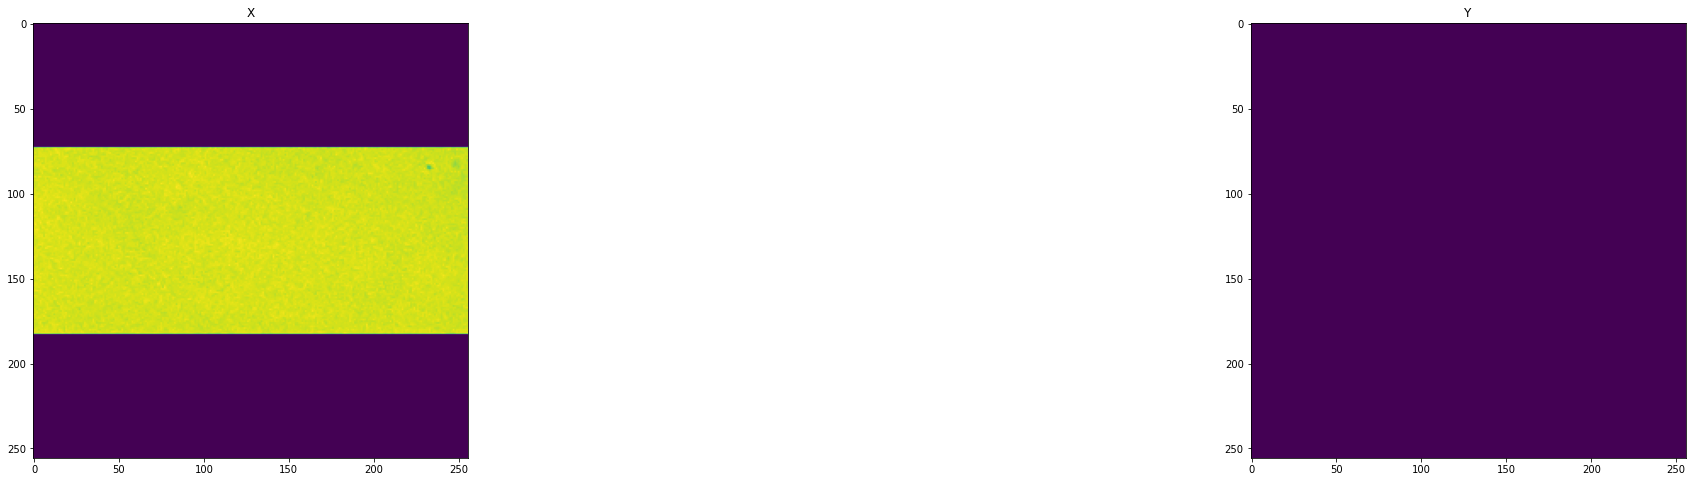

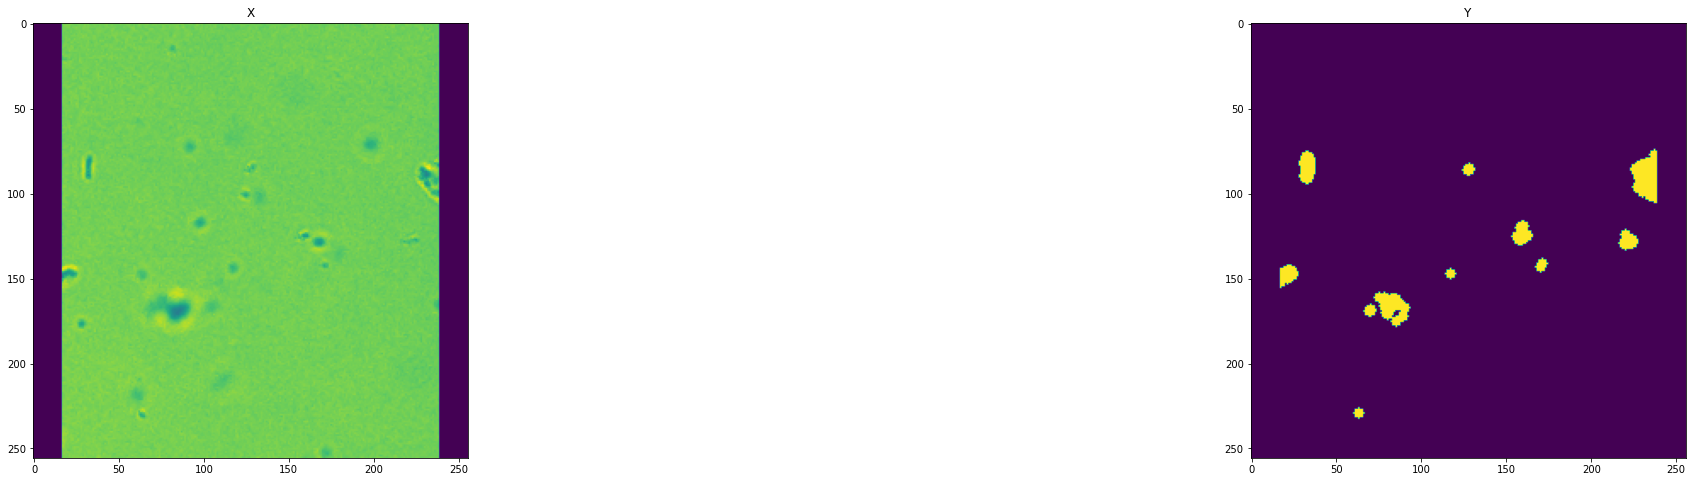

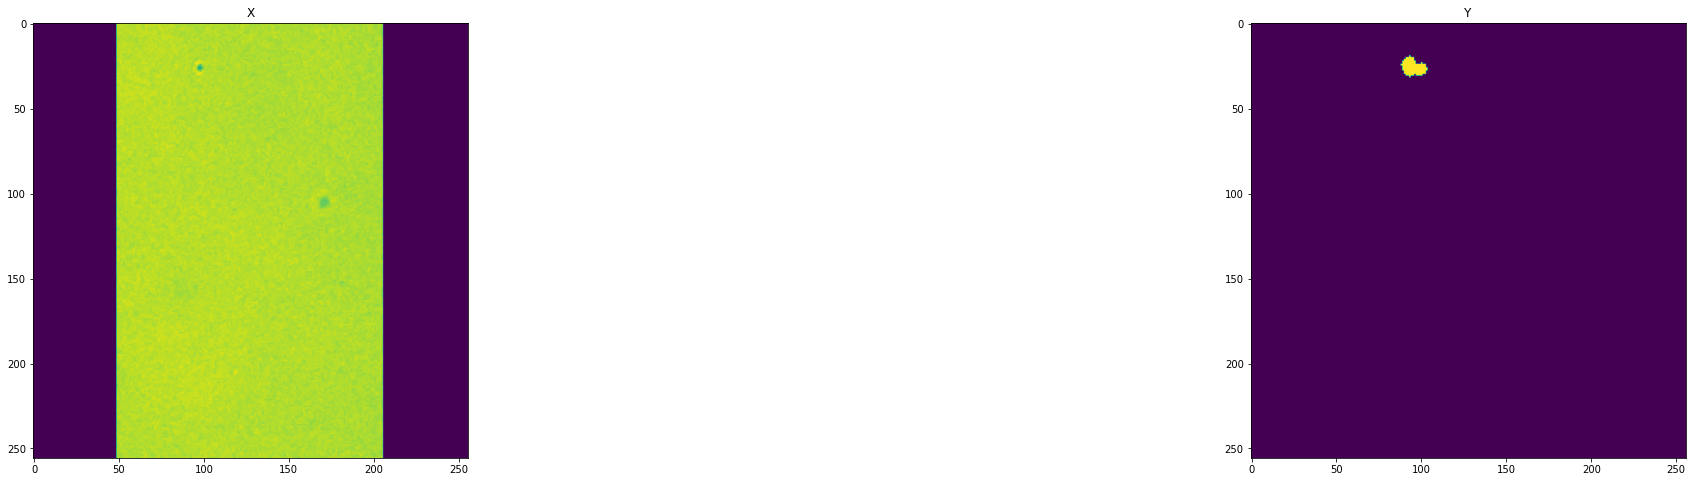

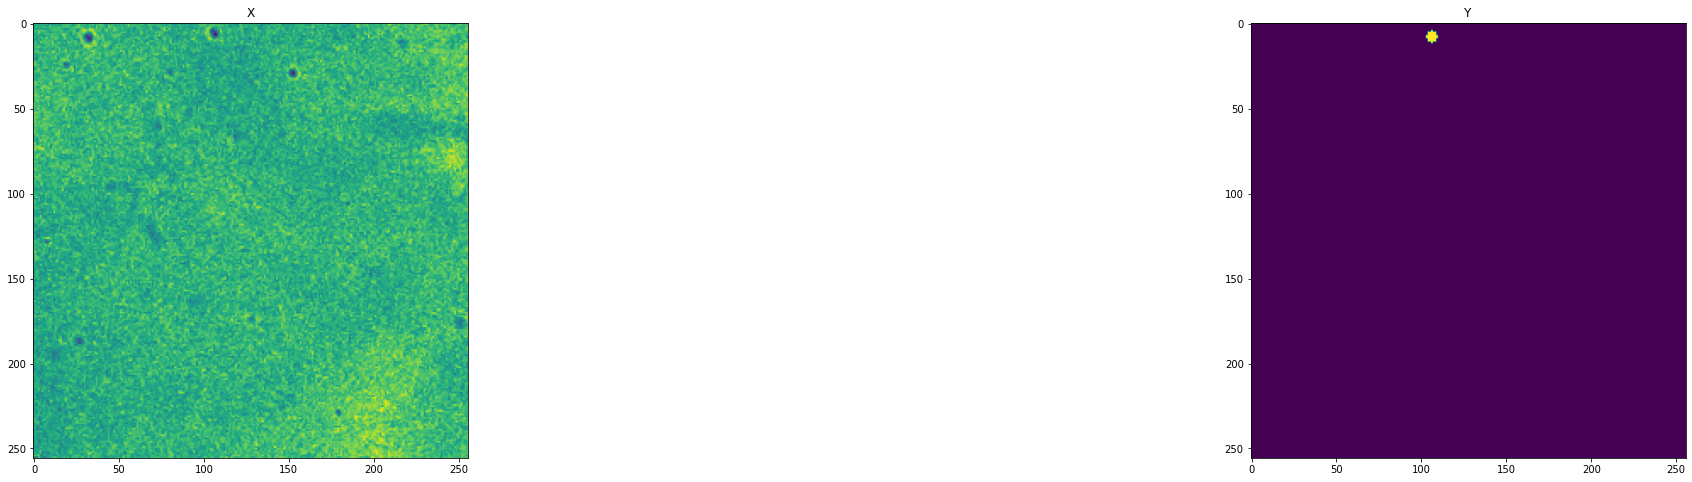

In [30]:
result = image_mask_generator.next()
test_img_exmp, test_mask_exmp = result[0], result[1]

for i in range(test_img_exmp.shape[0]):
    x = test_img_exmp[i]
    y = test_mask_exmp[i]
    plt.figure(figsize=(40,8))
    plt.subplot(1, 2, 1)
    plt.title('X')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 2, 2)
    plt.title('Y')
    plt.imshow(np.squeeze(y))

In [28]:
history = model.fit(
        image_mask_generator,
        batch_size = batch_size,
        steps_per_epoch=1+training_imgs.shape[0] // batch_sizes, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=image_mask_generator_test, validation_steps=1,
        callbacks=callbacksList)

Epoch 1/100


2022-06-16 13:06:52.930260: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


1/1 [==============================] - 8s 8s/step - loss: 0.9317 - dice_coeff: 0.0683 - val_loss: 0.9423 - val_dice_coeff: 0.0577
Epoch 2/100
1/1 [==============================] - 0s 383ms/step - loss: 0.9748 - dice_coeff: 0.0252 - val_loss: 0.9543 - val_dice_coeff: 0.0457
Epoch 3/100
1/1 [==============================] - 0s 380ms/step - loss: 0.9774 - dice_coeff: 0.0226 - val_loss: 0.9527 - val_dice_coeff: 0.0473
Epoch 4/100
1/1 [==============================] - 0s 369ms/step - loss: 0.9575 - dice_coeff: 0.0425 - val_loss: 0.9899 - val_dice_coeff: 0.0101
Epoch 5/100
1/1 [==============================] - 0s 384ms/step - loss: 0.9707 - dice_coeff: 0.0293 - val_loss: 0.9606 - val_dice_coeff: 0.0394
Epoch 6/100
1/1 [==============================] - 0s 379ms/step - loss: 0.9772 - dice_coeff: 0.0228 - val_loss: 0.9367 - val_dice_coeff: 0.0633
Epoch 7/100
1/1 [==============================] - 0s 377ms/step - loss: 0.9469 - dice_coeff: 0.0531 - val_loss: 0.9075 - val_dice_coeff: 0.0925


In [31]:
run["model/evaluation/loss"] = history.history['loss']
run["model/evaluation/dice_coeff"] = history.history['dice_coeff']
run["model/evaluation/val_loss"] = history.history['val_loss']
run["model/evaluation/val_dice_coeff"] = history.history['val_dice_coeff']

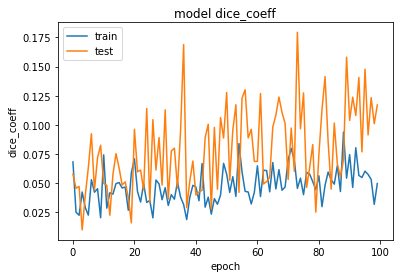

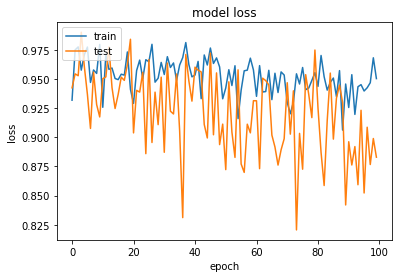

In [33]:
# summarize history for accuracy
plt.plot(history.history['dice_coeff'])
plt.plot(history.history['val_dice_coeff'])
plt.title('model dice_coeff')
plt.ylabel('dice_coeff')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(log_dir,'dice_coeff.png'), bbox_inches='tight', dpi=300)
plt.show()
run["model/evaluation/dice_coeff_plot"].upload(os.path.join(log_dir,"dice_coeff.png"))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(log_dir,'loss.png'), bbox_inches='tight', dpi=300)
plt.show()
run["model/evaluation/loss_plot"].upload(os.path.join(log_dir,"loss.png"))

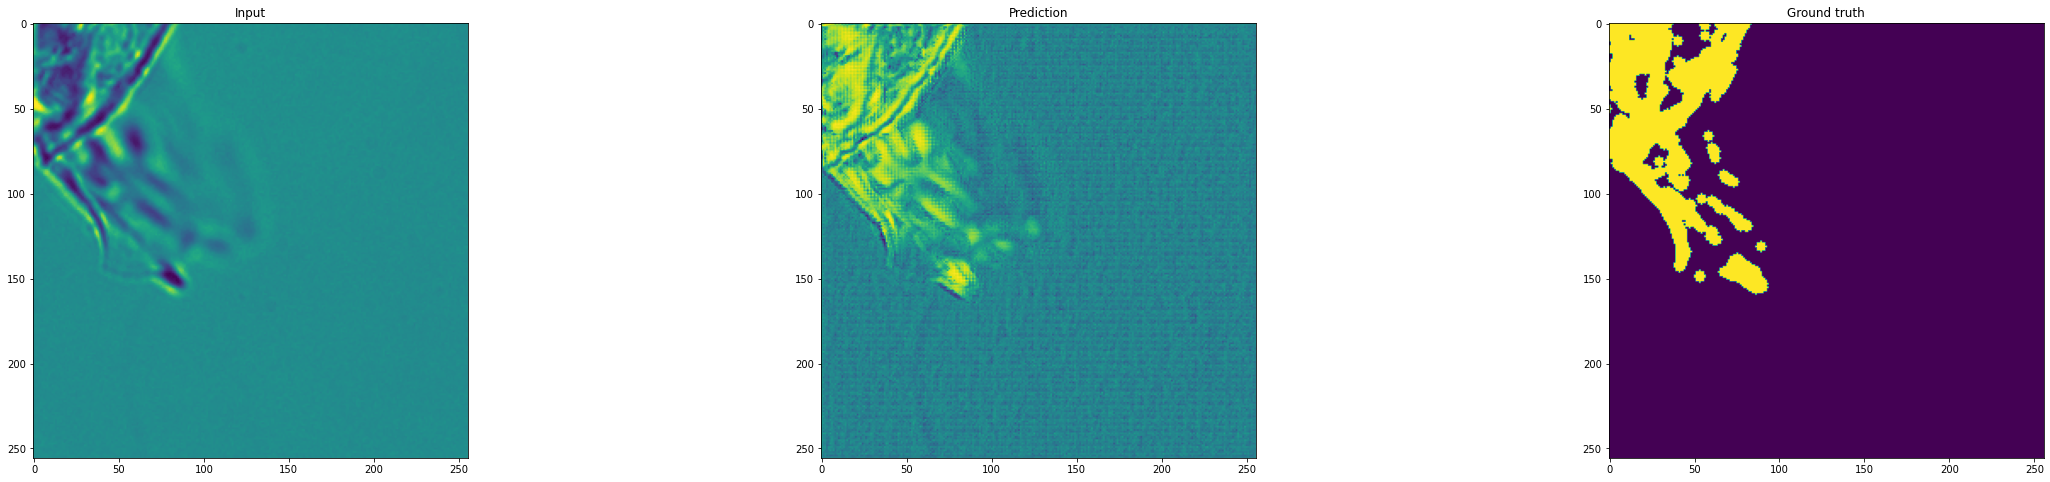

In [67]:
result = image_mask_generator_test.next()
img_exmp, mask_exmp = result[0], result[1]
test_model(model, img_exmp, mask_exmp, log_dir)

In [68]:
run["model/evaluation/test_output"].upload(os.path.join(log_dir,"ground_truth_etest.png"))

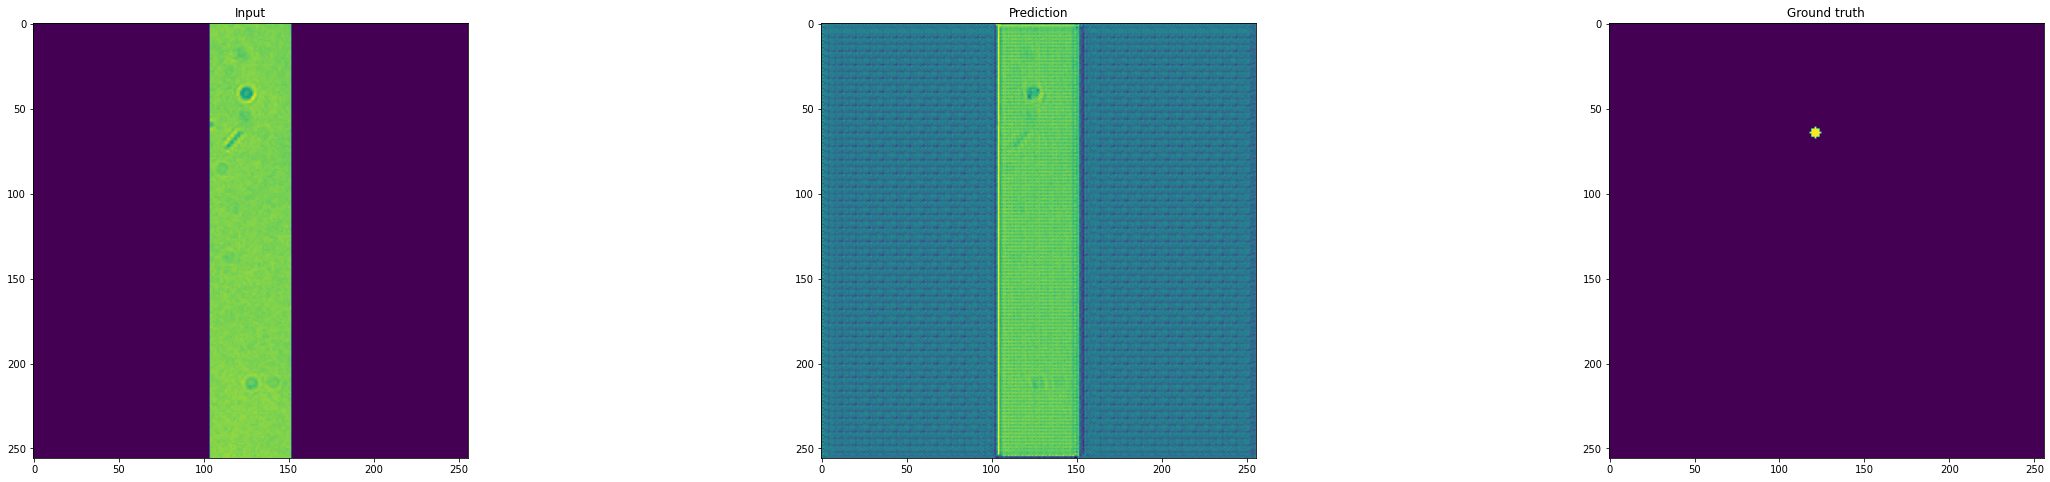

In [69]:
result = image_mask_generator_test.next()
img_exmp, mask_exmp = result[0], result[1]
test_model(model, test_img_exmp, test_mask_exmp, log_dir)

In [58]:
model.save(os.path.join(log_dir,runningTime+'.h5'))

run["model/saved_model"].upload(os.path.join(log_dir,runningTime+'.h5'))

In [59]:
from tensorflow import keras

reloaded_model = keras.models.load_model(os.path.join(log_dir,runningTime+'.h5'),custom_objects = {"dice_loss": unet7.dice_loss, "dice_coeff": unet7.dice_coeff})
reloaded_model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

In [70]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/mlid/DeepUTI/e/DUTI-3


#### Custom function for flow_from_directory() with image and mask as part of same generator

In [15]:
#target_size for flow_from_directory() should be the original size and later 
# on will get into patches following the arguments in the image data generator

from custom_keras_class_v2 import *

In [46]:
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(
    project="mlid/DeepUTI",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0Y2JmNWIzMS1hYmMyLTQ2ODUtODVmNy02MWJiNzBlODQ0M2MifQ==",  
)

https://app.neptune.ai/mlid/DeepUTI/e/DUTI-13
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/home/de29/.conda/envs/deeputi/lib/python3.10/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/de29/.conda/envs/deeputi/lib/python3.10/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


In [47]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
epochs = 100 #100 1001
batch_size = 8
smooth = 1.
start_lr = 1e-4
target_width = 256
target_height = 256

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_rows / target_height

In [48]:
parameters = {
    "img_cols": 1392,
    "img_rows": 1040,
    "epochs": 10,
    "batch_size": 8,
    "smooth": 1.,
    "start_lr": 1e-4,
    "target_width": 256,
    "target_height": 256,
    "upscale_factor_width": img_cols/ target_width,
    "upscale_factor_height": img_rows/ target_height
}

run["model/parameters"] = parameters

In [19]:
runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = os.path.join('..','data')
log_dir = os.path.join(model_dir, 'Practice','logs',"{}".format(runningTime))
checkDir(log_dir)

In [50]:
# Add additional parameters
run["model/parameters/runningTime"] = runningTime
run["model/parameters/model_dir"] = model_dir
run["model/parameters/log_dir"] = log_dir

# Update parameters. For example, after triggering early stopping
# run["model/parameters/n_epochs"] = epoch

In [16]:
# Training


tensorboard = TensorBoard(log_dir=os.path.join(model_dir,"{}".format(runningTime)),histogram_freq = 1)
#tensorboard = TensorBoard(log_dir=log_dir)

filepath = 'model.epoch{epoch:03d}.hdf5'
checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,filepath), 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
# callbacksList = [tensorboard,checkpoint,NeptuneCallback(run=run)]
callbacksList = [tensorboard,checkpoint]

#model = unet7.get_unet(img_cols, img_rows)
model = unet7.Unet(target_width, target_width, nclasses=1)

#model.compile(optimizer=Adam(lr=5e-5), loss=unet7.dice_coef_loss, metrics=[unet7.dice_coef])
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=start_lr,
    decay_steps=10,
    decay_rate=0.9)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss=unet7.dice_loss, metrics=[unet7.dice_coeff])

model.summary()
#print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(model_dir,"{}".format(runningTime)+"\""))
print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir+"\""))

2022-10-27 11:40:55.716542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 6.0


Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

In [52]:
run["model/samples/before_dilation"].upload(os.path.join('../data/Practice/logs/Jun-16-2022_12-39',"before_dilation.png"))
run["model/samples/after_dilation"].upload(os.path.join('../data/Practice/logs/Jun-16-2022_12-39',"after_dilation.png"))

In [21]:
# %reload_ext tensorboard
# %tensorboard --logdir="../data/Practice/logs/Sep-29-2022_14-20" serve

In [17]:
# Data augmentation of training images and masks

# sets defining what which transformations are applicable to which
image_tf = dict(samplewise_center=True,
                samplewise_std_normalization=True,
                vertical_flip=True,
                horizontal_flip=True,
                preprocessing_function=False,
                fill_mode=True,
                max_iter = True,
                thresh_obj_perc = True,
                target_width = True,
                target_height = True
                    
                )
mask_tf = dict(samplewise_center=False,
                samplewise_std_normalization=False,
                vertical_flip=True,
                horizontal_flip=True,
                preprocessing_function=True,
                fill_mode=True,
                max_iter = True,
                thresh_obj_perc = True,
                target_width = True,
                target_height = True
                    
                )

img_mask_gen_args = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=True,
                    horizontal_flip=True,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = 10,
                    thresh_obj_perc = 0.25,
                    target_width = 256,
                    target_height = 256,
                    image_aug_check = image_tf,
                    mask_aug_check = mask_tf
                     )

image_mask_datagen = customImageDataGenerator(**img_mask_gen_args)

seed = 123
image_mask_datagen.fit(training_imgs,image_tf,augment=True, seed=seed)
image_mask_generator = image_mask_datagen.flow_from_directory(
        # directory_x = '/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-img/',
        # directory_y = '/bigdata/casus/MLID/DeepUTI/ucl/dataset1/dataset1-processed_mask/',
        directory_x = '/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/img/',
        directory_y = '/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed/',
        target_size=(1040,1392),
        color_mode="grayscale",
        classes=None,
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
        keep_aspect_ratio=True)

Found 10 images belonging to 1 classes.


In [18]:
# Data augmentation of validation images and masks

img_mask_gen_args_val = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=True,
                    horizontal_flip=True,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = 10,
                    thresh_obj_perc = 0.25,
                    target_width = 256,
                    target_height = 256,
                    image_aug_check = image_tf,
                    mask_aug_check = mask_tf
                     )

image_mask_datagen_val = customImageDataGenerator(**img_mask_gen_args_val)

seed = 123
image_mask_datagen_val.fit(test_imgs,image_tf, augment=True, seed=seed)
image_mask_generator_val = image_mask_datagen_val.flow_from_directory(
        directory_x = '/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/img/',
        directory_y = '/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed/',
        target_size= (1040, 1392),
        color_mode="grayscale",
        classes=None,
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
        keep_aspect_ratio=True)

Found 10 images belonging to 1 classes.


In [19]:
# Data augmentation of test images and masks

img_mask_gen_args_test = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=True,
                    horizontal_flip=True,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = 10,
                    thresh_obj_perc = 0.25,
                    target_width = 256,
                    target_height = 256,
                    image_aug_check = image_tf,
                    mask_aug_check = mask_tf
                     )

image_mask_datagen_test = customImageDataGenerator(**img_mask_gen_args_test)

seed = 123
image_mask_datagen_test.fit(test_imgs,image_tf, augment=True, seed=seed)
image_mask_generator_test = image_mask_datagen_test.flow_from_directory(
        directory_x = '/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/img/',
        directory_y = '/bigdata/casus/MLID/DeepUTI/ucl/Debug_set/mask/preprocessed/',
        target_size= (1040, 1392),
        color_mode="grayscale",
        classes=None,
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
        keep_aspect_ratio=True)

Found 10 images belonging to 1 classes.


In [20]:
print(tf.shape(image_mask_generator.next()))

tf.Tensor([  2  10 256 256   1], shape=(5,), dtype=int32)


In [21]:
print(tf.shape(image_mask_generator_val.next()))

tf.Tensor([  2  10 256 256   1], shape=(5,), dtype=int32)


In [22]:
print(tf.shape(image_mask_generator_test.next()))

tf.Tensor([  2  10 256 256   1], shape=(5,), dtype=int32)


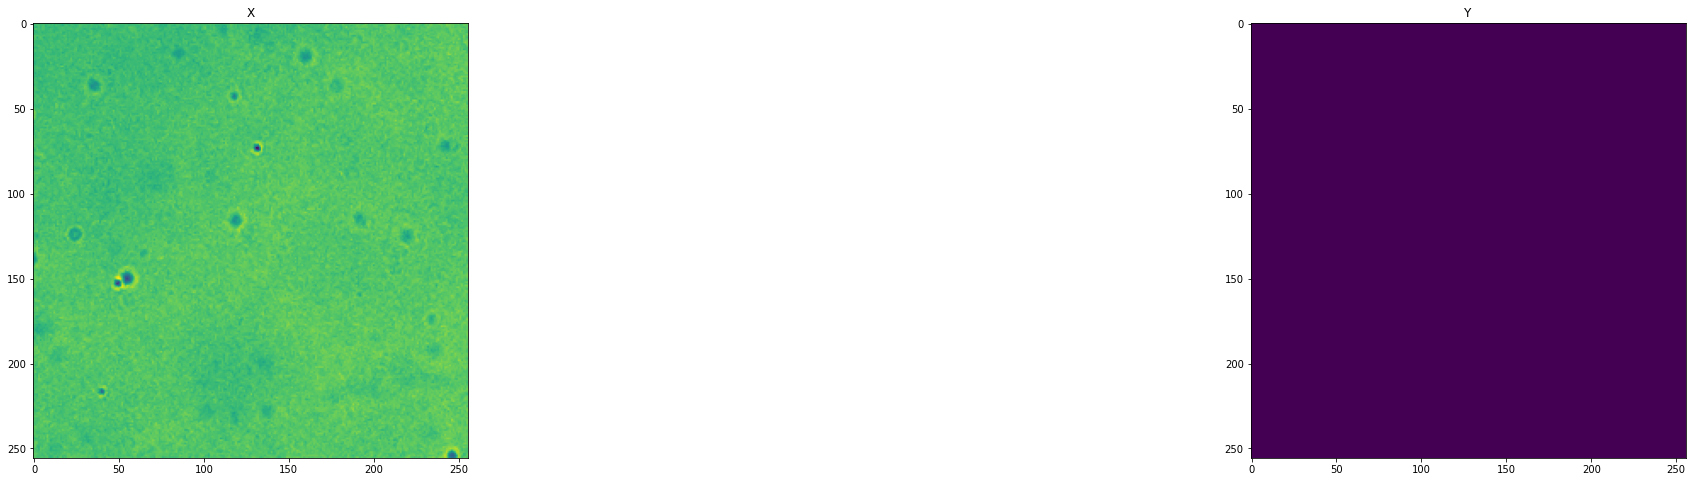

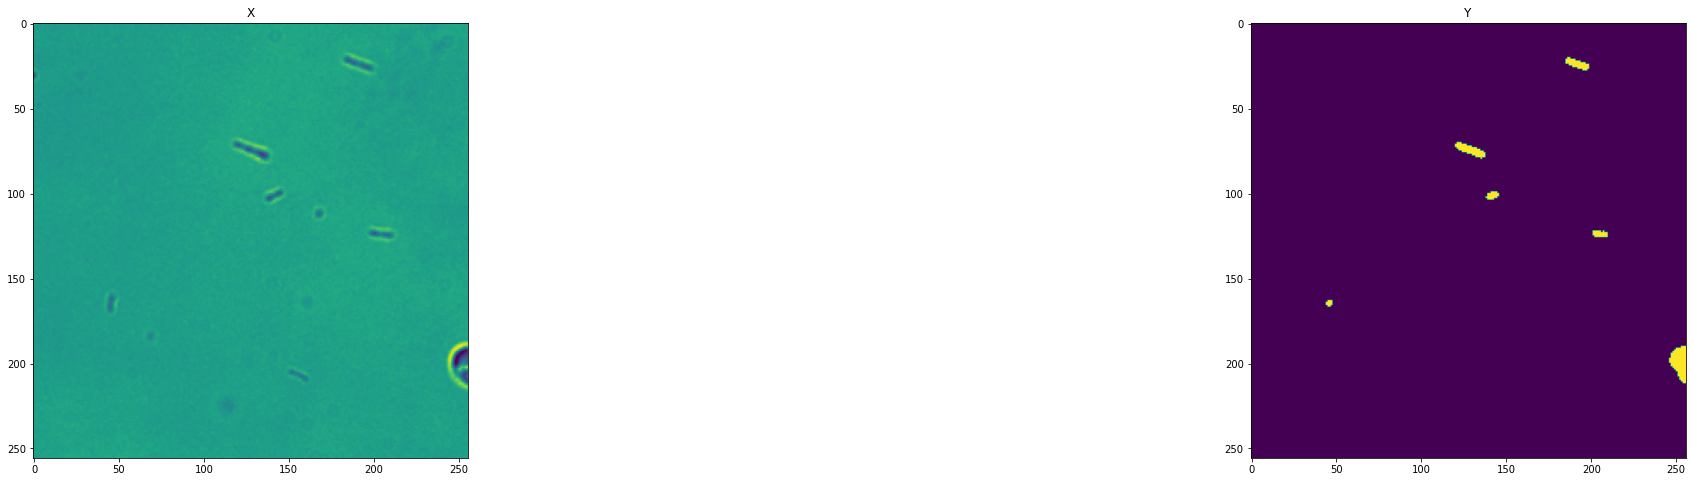

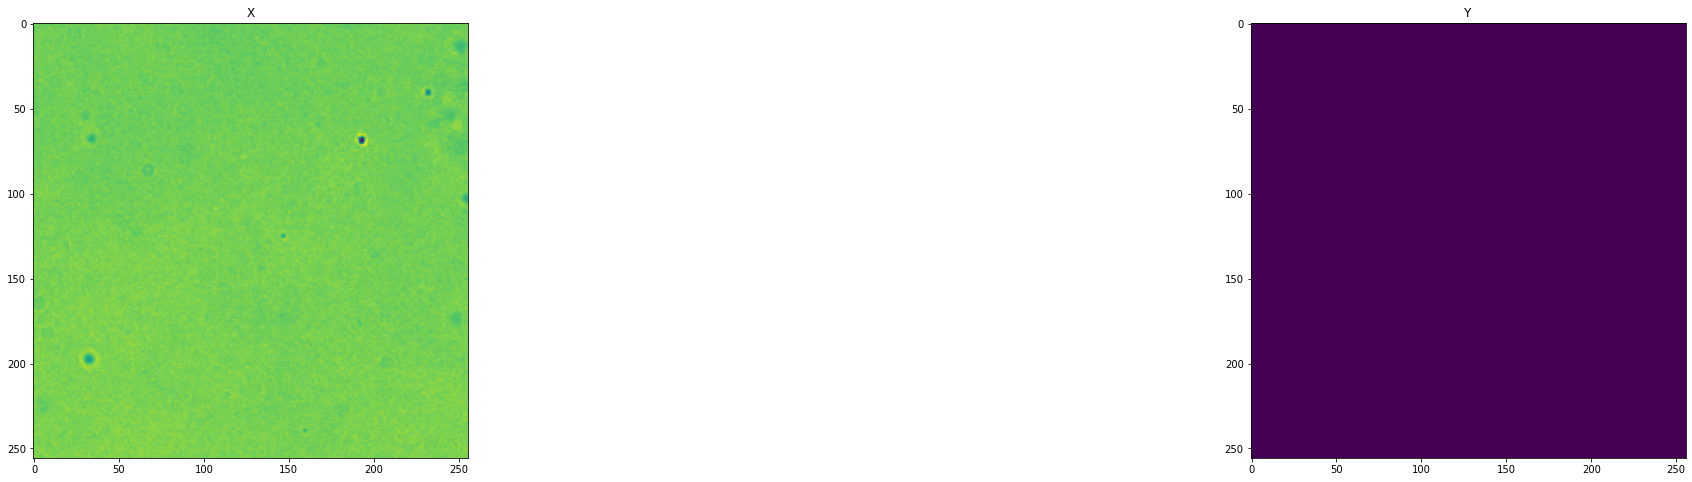

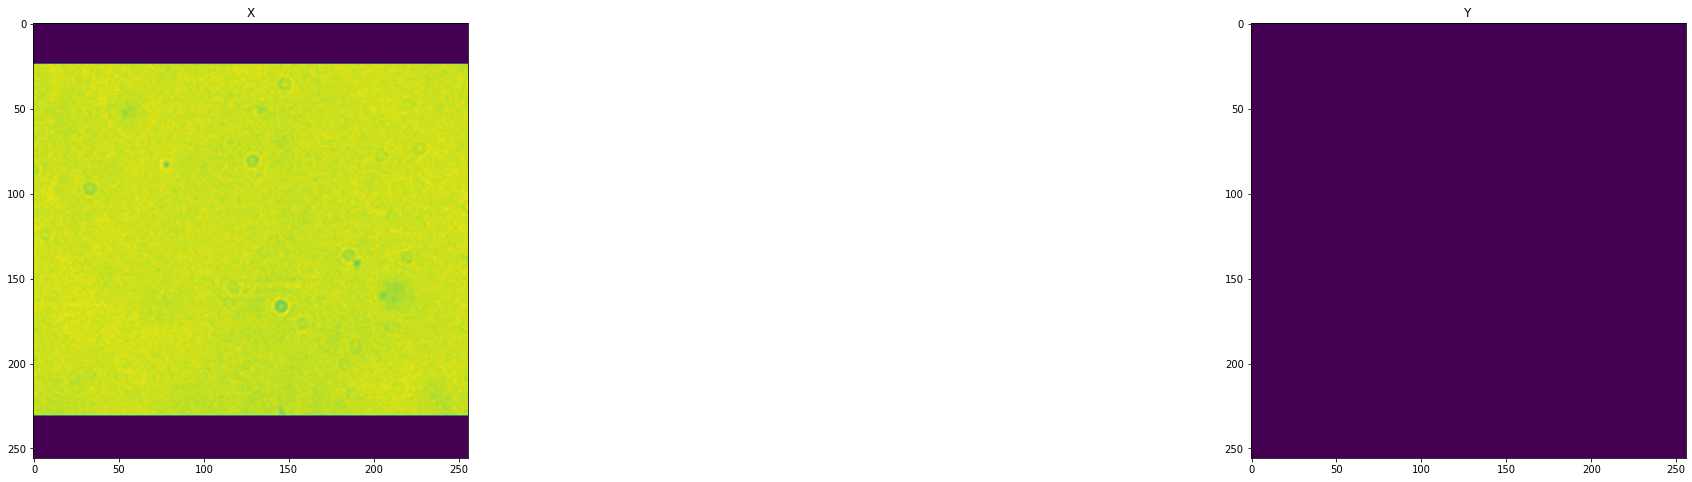

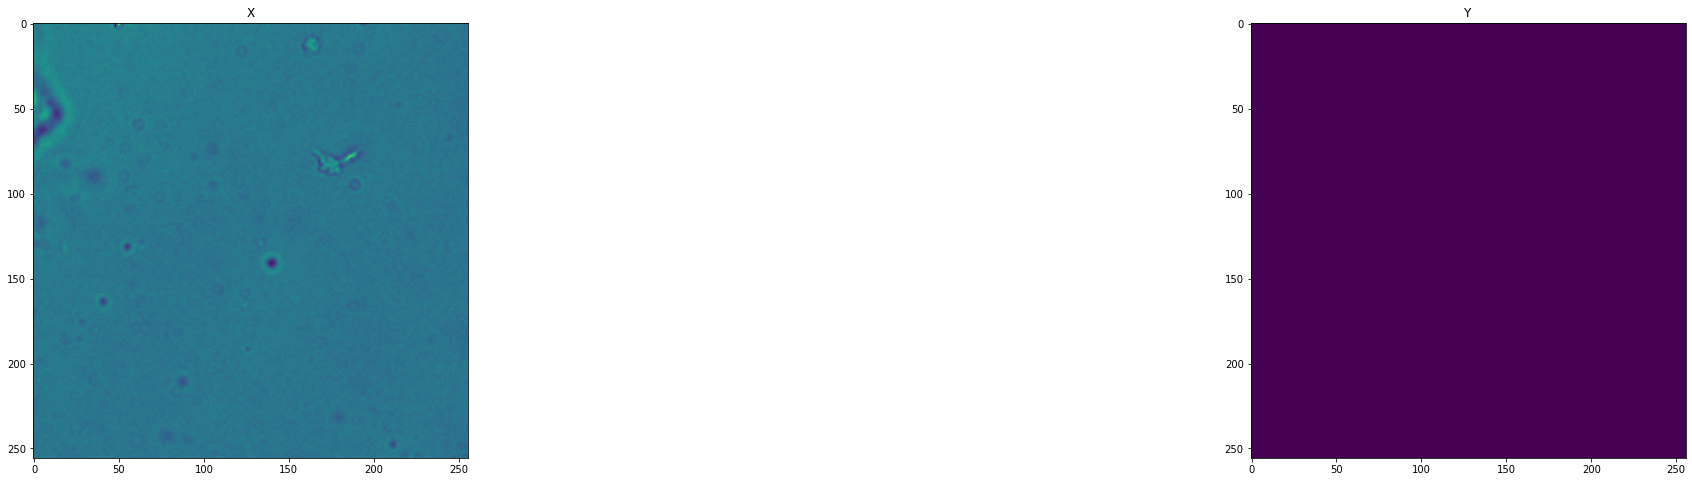

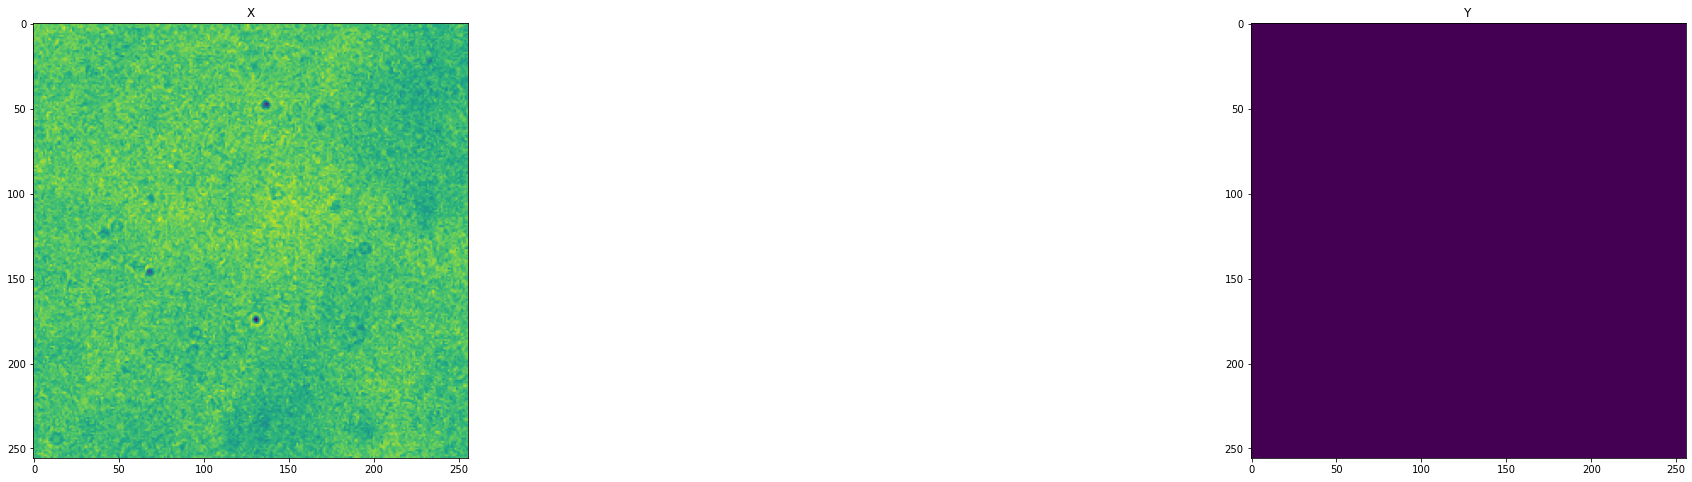

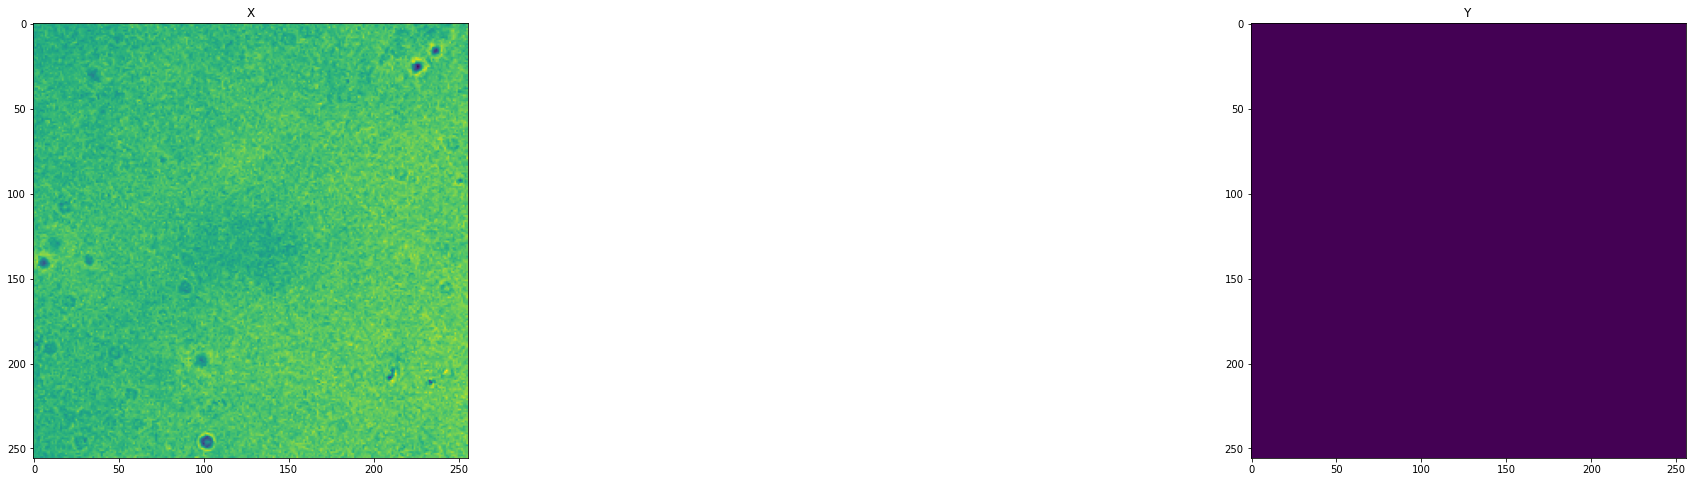

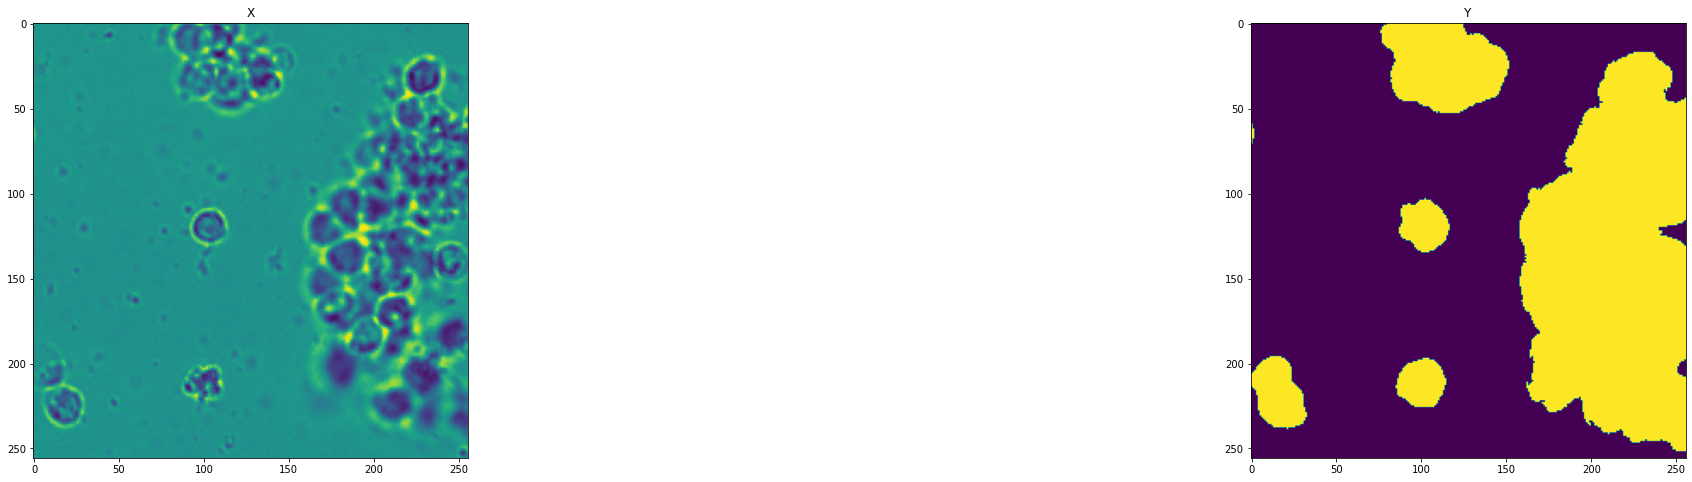

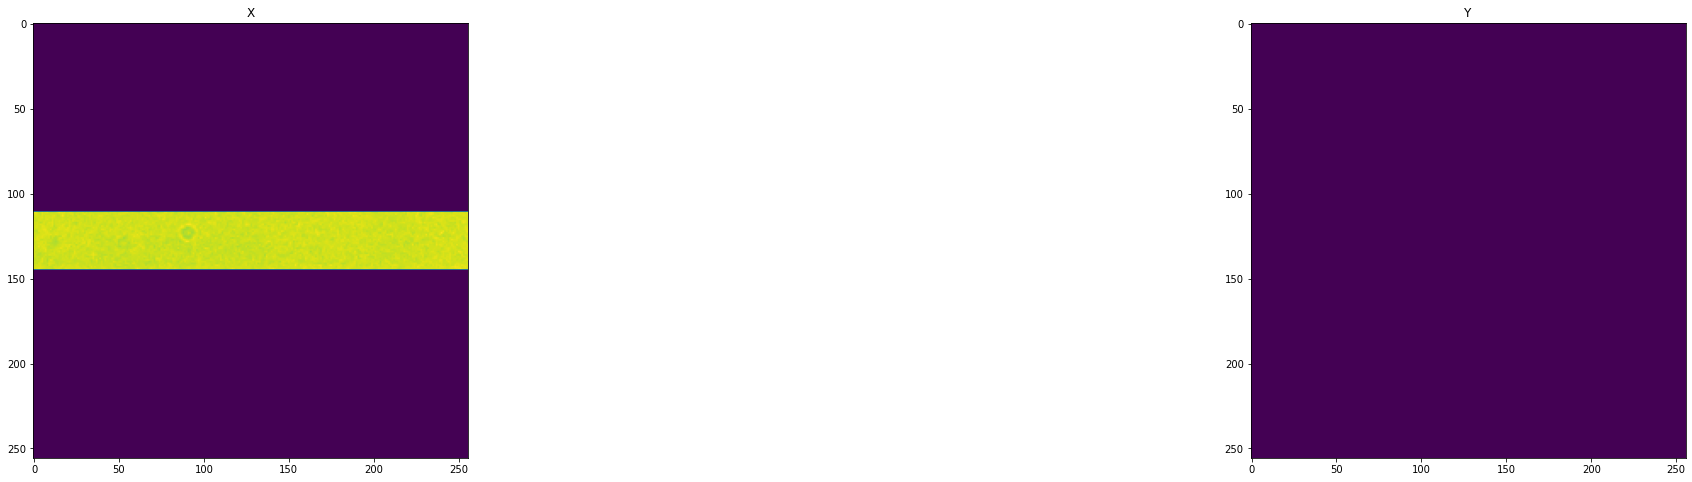

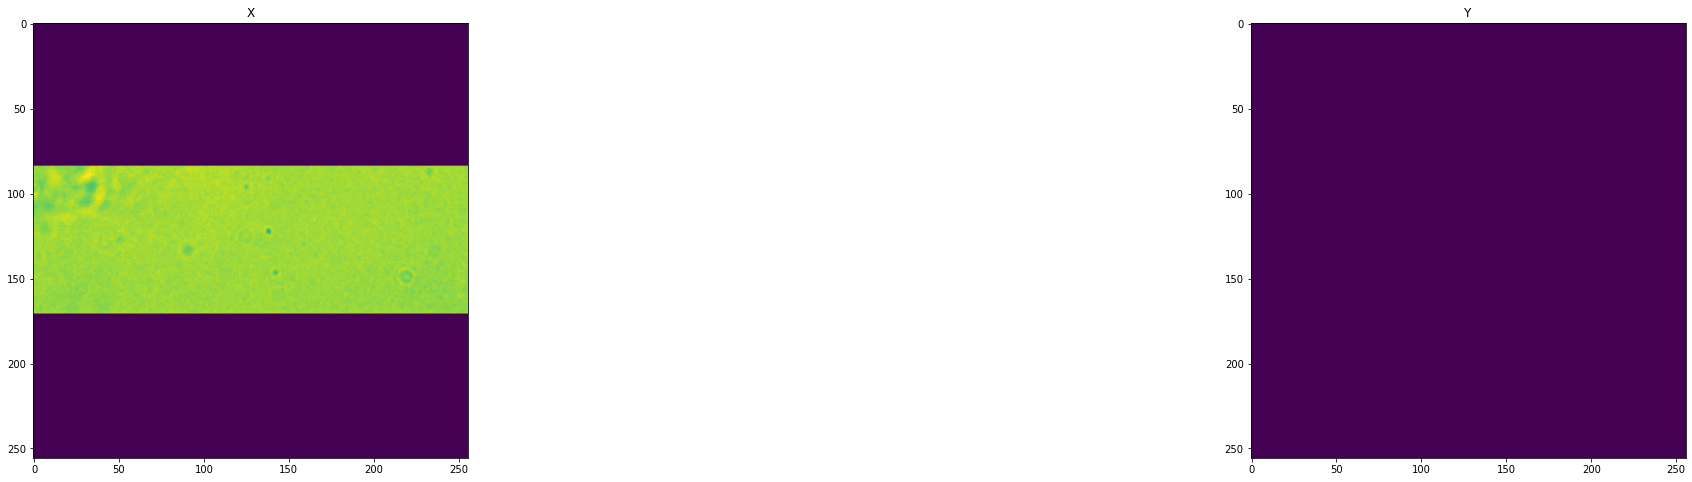

In [23]:
result = image_mask_generator_test.next()
test_img_exmp, test_mask_exmp = result[0], result[1]

for i in range(test_img_exmp.shape[0]):
    x = test_img_exmp[i]
    y = test_mask_exmp[i]
    plt.figure(figsize=(40,8))
    plt.subplot(1, 2, 1)
    plt.title('X')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 2, 2)
    plt.title('Y')
    plt.imshow(np.squeeze(y))

In [47]:
history = model.fit(
        image_mask_generator,
        batch_size = batch_size,
        steps_per_epoch=1, #200, 40
#         steps_per_epoch=10000 // batch_size, #correct value
        epochs=epochs,
        validation_freq = 1,
        validation_data=image_mask_generator_val, validation_steps=1,
        callbacks=callbacksList)

Epoch 1/100


2022-10-12 11:41:34.813024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


50/50 [==============================] - ETA: 0s - loss: 0.9579 - dice_coeff: 0.0510
Epoch 1: val_loss improved from inf to 0.96798, saving model to ../data/Practice/logs/Oct-12-2022_10-45/model.epoch001.hdf5
50/50 [==============================] - 179s 3s/step - loss: 0.9579 - dice_coeff: 0.0510 - val_loss: 0.9680 - val_dice_coeff: 0.0320
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.9490 - dice_coeff: 0.0606
Epoch 2: val_loss improved from 0.96798 to 0.95239, saving model to ../data/Practice/logs/Oct-12-2022_10-45/model.epoch002.hdf5
50/50 [==============================] - 162s 3s/step - loss: 0.9490 - dice_coeff: 0.0606 - val_loss: 0.9524 - val_dice_coeff: 0.0476
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.9412 - dice_coeff: 0.0739
Epoch 3: val_loss improved from 0.95239 to 0.92824, saving model to ../data/Practice/logs/Oct-12-2022_10-45/model.epoch003.hdf5
50/50 [==============================] - 164s 3s/step - loss: 0.9412 - di

In [59]:
run["model/evaluation/loss"] = history.history['loss']
run["model/evaluation/dice_coeff"] = history.history['dice_coeff']
run["model/evaluation/val_loss"] = history.history['val_loss']
run["model/evaluation/val_dice_coeff"] = history.history['val_dice_coeff']

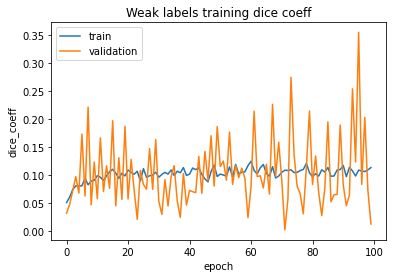

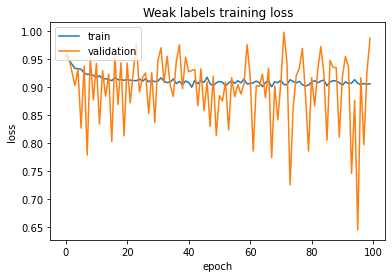

In [50]:
# summarize history for accuracy
plt.plot(history.history['dice_coeff'])
plt.plot(history.history['val_dice_coeff'])
plt.title('Weak labels training dice coeff')
plt.ylabel('dice_coeff')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(log_dir,'dice_coeff.svg'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(log_dir,'dice_coeff.png'), bbox_inches='tight', dpi=300)
plt.show()
# run["model/evaluation/dice_coeff_plot"].upload(os.path.join(log_dir,"dice_coeff.png"))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Weak labels training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(log_dir,'loss.svg'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(log_dir,'loss.png'), bbox_inches='tight', dpi=300)
plt.show()
# run["model/evaluation/loss_plot"].upload(os.path.join(log_dir,"loss.png"))

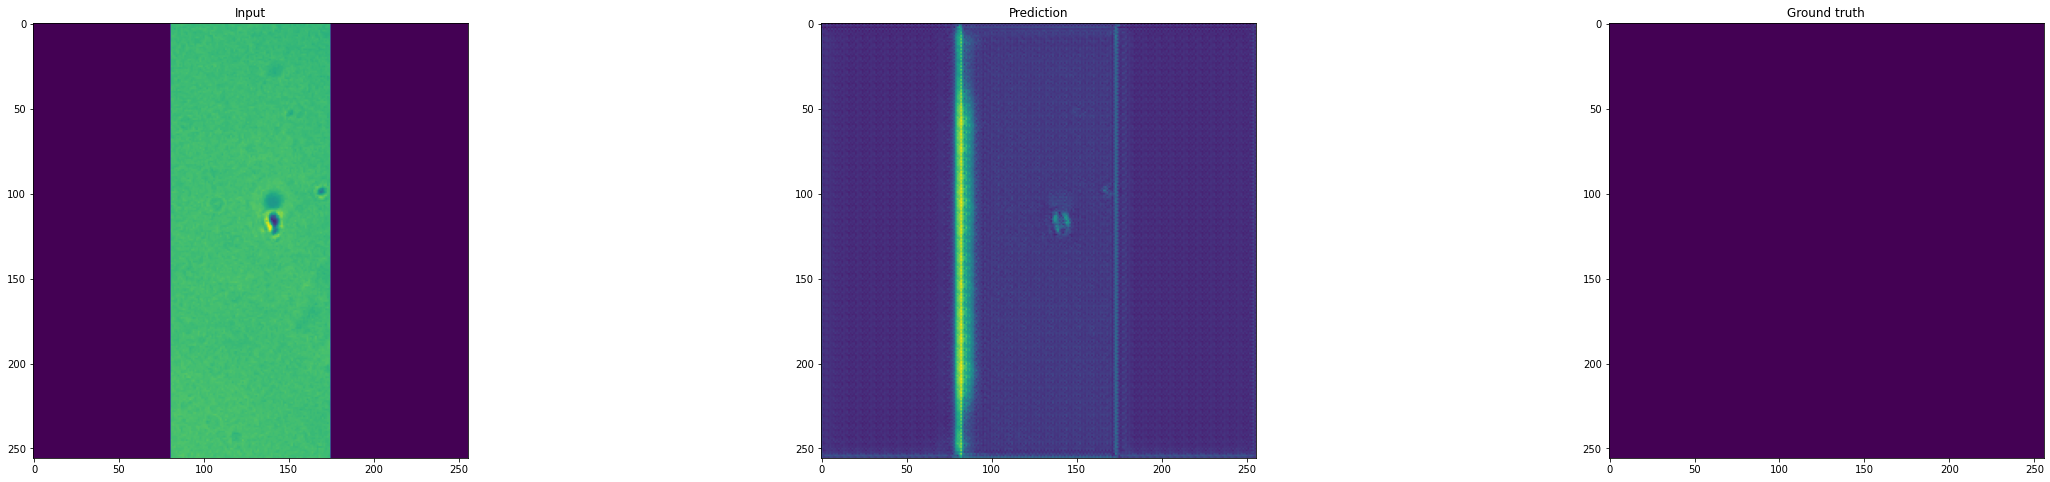

In [51]:
result = image_mask_generator_test.next()
img_exmp, mask_exmp = result[0], result[1]
test_model(model, img_exmp, mask_exmp, log_dir)

In [67]:
run["model/evaluation/test_output"].upload(os.path.join(log_dir,"ground_truth_etest.png"))

In [35]:
# model.save(os.path.join(log_dir,runningTime+'.h5'))

# run["model/saved_model"].upload(os.path.join(log_dir,runningTime+'.h5'))

In [67]:
# Finding the best model in the directory
import glob

log_dir = '../data/Practice/logs/Oct-04-2022_11-32'
checkpoints = glob.glob(log_dir+'/'+'*.hdf5')
ckp_nr = []
ckp_str = []
substr = '.hdf5'
for ckp in checkpoints:
    index = ckp.find(substr)
    ckp_nr.append(int(ckp[index-3:index]))
    ckp_str.append(ckp[index-3:index])  
    
ckp_nr, ckp_str = zip(*sorted(zip(ckp_nr, ckp_str)))

best_model = os.path.join(log_dir,'model.epoch'+ckp_str[-1]+'.hdf5')
best_model

'../data/Practice/logs/Oct-04-2022_11-32/model.epoch096.hdf5'

In [68]:
from tensorflow import keras

reloaded_model = keras.models.load_model(best_model,custom_objects = {"dice_loss": unet7.dice_loss, "dice_coeff": unet7.dice_coeff})
reloaded_model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 8)  32         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                               

In [70]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/mlid/DeepUTI/e/DUTI-13


#### Making patches out of test images to get average performance metric using the previously trained best model

In [54]:
from itertools import product
import matplotlib.pyplot as plt

def sequenced_patchified_predict(img,d,model):
    #Takes an image and a given size and returns chunks of that image as a list but in an ordered sequence
    w, h = img.size
    # name = 'img'
    # ext = '.png'
    # fig, axarr = plt.subplots(h-h%d+1,w-w%d+1)
    pred = np.zeros(img.size)
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        # out = os.path.join('../data/Practice/logs/Oct-11-2022_13-07', f'{name}_{i}_{j}{ext}')
        pred[j:j+d,i:i+d] = model.predict(img.crop(box))
    return pred

In [55]:
def divide_img_blocks(img, n_blocks=(1280//256, 1536//256)):
    horizontal = np.array_split(img, n_blocks[0])
    # print(len(horizontal))
    splitted_img = [np.array_split(block, n_blocks[1], axis=1) for block in horizontal]
    # print(len(splitted_img))
    return np.asarray(splitted_img, dtype=np.ndarray)

def combine_img_blocks(img_array):
    combined_img = np.array([])
    for i in range(img_array.shape[0]):
        temp = np.array([])
        for j in range(img_array.shape[1]):
            temp = np.hstack([temp,np.squeeze(img_array[i,j])]).astype(np.float32) if temp.size else np.squeeze(img_array[i,j])
        combined_img = np.vstack([combined_img,temp]).astype(np.float32) if combined_img.size else temp

    return combined_img

In [56]:
test_image_tf = dict(samplewise_center=True,
                samplewise_std_normalization=True,
                vertical_flip=False,
                horizontal_flip=False,
                preprocessing_function=False,
                fill_mode=True,
                max_iter = False,
                thresh_obj_perc = False,
                target_width = False,
                target_height = False
                    
                )
test_mask_tf = dict(samplewise_center=False,
                samplewise_std_normalization=False,
                vertical_flip=False,
                horizontal_flip=False,
                preprocessing_function=True,
                fill_mode=True,
                max_iter = False,
                thresh_obj_perc = False,
                target_width = False,
                target_height = False
                    
                )

img_mask_args_avg_test_per = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    vertical_flip=False,
                    horizontal_flip=False,
                    preprocessing_function=np.rint,
                    fill_mode='nearest',
                    max_iter = None,
                    thresh_obj_perc = 0.99,
                    target_width = 1392,
                    target_height = 1040,
                    image_aug_check = test_image_tf,
                    mask_aug_check = test_mask_tf
                     )

image_mask_datagen_avg_test_per = customImageDataGenerator(**img_mask_args_avg_test_per)


In [65]:
# Code to get patches of all the test images and then calculate the average 
#dice coeff between them and their predicted counterparts
import glob

#test_imgs/masks_path without '/' at the end
def average_performance(test_imgs_path,test_masks_path,model): 
    dice_coeff_ls = []
    for f in glob.glob(test_imgs_path+'/*.tif'):
        img_path = f
        msk_path = test_masks_path+'/'+f.split('/')[-1].replace('.tif','_Simple Segmentation.tif')

        
        try:   
            img = load_img(
                    img_path,
                    color_mode="grayscale",
                    target_size=(1040,1392),
                    interpolation="nearest",
                    keep_aspect_ratio=True,
                )
            mask = load_img(
                    msk_path,
                    color_mode="grayscale",
                    target_size=(1040,1392),
                    interpolation="nearest",
                    keep_aspect_ratio=True,
                    )
            # print('objects read')
            x = img_to_array(img, data_format='channels_last')
            y = img_to_array(mask, data_format='channels_last')
            # Pillow images should be closed after `load_img`,
            # but not PIL images.
            if hasattr(img, "close"):
                img.close()
            if hasattr(mask, "close"):
                mask.close() 

            x = image_mask_datagen_avg_test_per.standardize(x,test_image_tf)
            y = image_mask_datagen_avg_test_per.standardize(y,test_mask_tf)
            # print('standardized')

            # print(x.shape)
            # print(y.shape)

            x_padded = np.pad(np.squeeze(x), ((0, ((1040//256+1)*256)-1040), (0, ((1392//256+1)*256)-1392)),
                                mode='constant', constant_values=0)
            # print(x_padded.shape)

            img_array = divide_img_blocks(np.expand_dims(x_padded,axis=-1), n_blocks=(1280//256, 1536//256))

            # print(img_array.shape)
            pred_array = np.empty_like(img_array)
            for i in range(img_array.shape[0]):
                for j in range(img_array.shape[1]): 
                    pred_array[i,j] = model.predict(tf.convert_to_tensor(img_array[i,j][np.newaxis],tf.float32))

            pred = combine_img_blocks(pred_array)
            # recombined_img  = combine_img_blocks(img_array)

            pred = np.float32(pred[:1040,:1392])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
            y = (y - y.min()) / (y.max() - y.min())

            if "5868 I 280921_Simple Segmentation.tif" in msk_path:
                plt.figure(figsize=(40,8))
                plt.subplot(1, 3, 1)
                plt.title('Input')
                plt.imshow(np.squeeze(x))

                plt.subplot(1, 3, 2)
                plt.title('Prediction')
                plt.imshow(np.squeeze(np.rint(pred)),cmap='gray')

                plt.subplot(1, 3, 3)
                plt.title('Ground truth')
                plt.imshow(np.squeeze(y),cmap='gray')

                plt.savefig(os.path.join(log_dir,'sample_ground_truth_{}.svg'.format('test')), bbox_inches='tight', dpi=300)
                plt.savefig(os.path.join(log_dir,'sample_ground_truth_{}.png'.format('test')), bbox_inches='tight', dpi=300)
                plt.show()
                # break

            # print(pred.shape)
            # print(pred.dtype)
            # print(y.shape)
            # print(y.dtype)
            # print('patchified')
            dice_coeff_ls.append(unet7.dice_coeff(np.squeeze(y),pred))
            # break
            print(f)
        except:
            continue
    print(len(dice_coeff_ls))
    
    return np.mean(dice_coeff_ls)

/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8398 G 051021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8029 C 231021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7691 C 310821.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8146 A 051021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7873 N 280921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7236 U 310821.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8341 V 070921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8090 O 280921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7390 M 091121.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7847 E 231021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7002 X 021021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/6598 B 031121.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7390 X 091121.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/6696 D 220

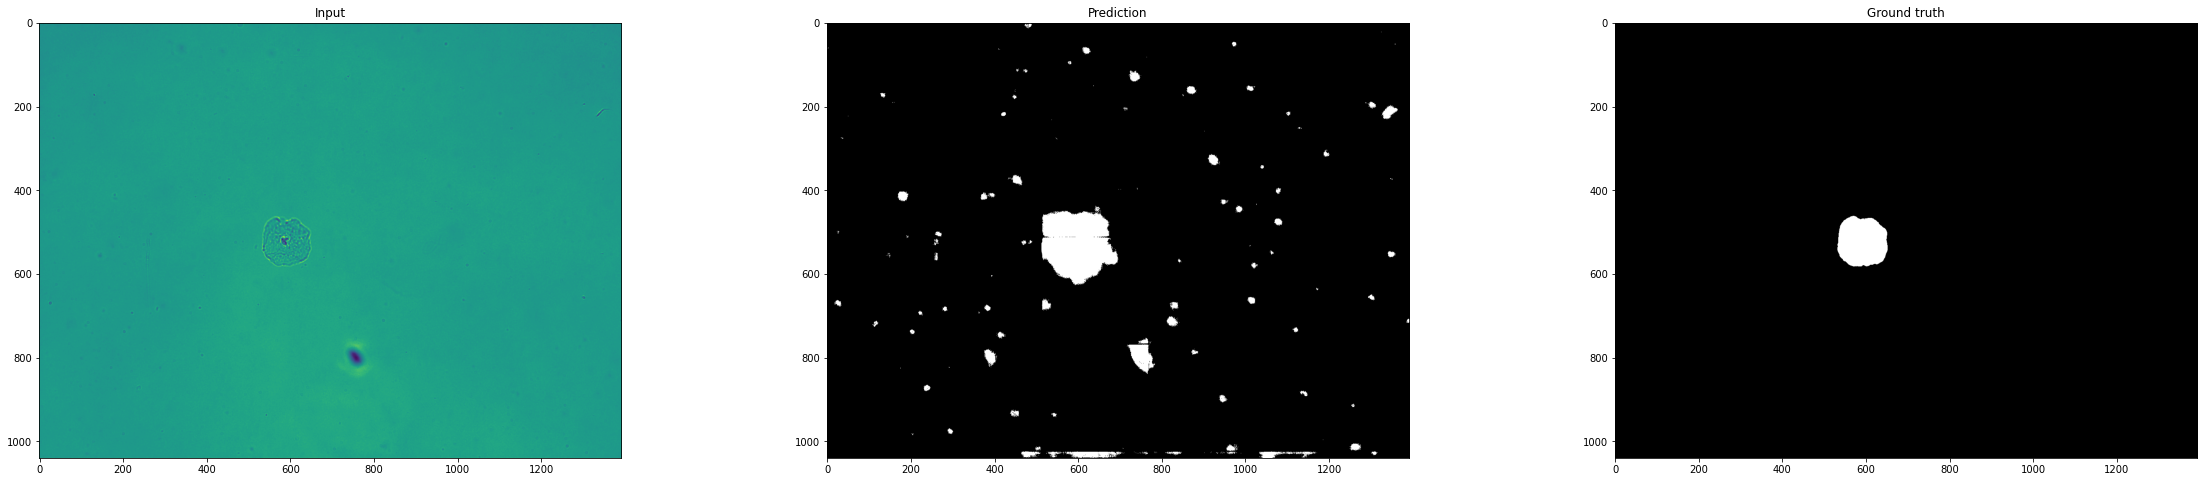

/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/5868 I 280921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/5821 C 280921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8225 K 070921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8072 E 010921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7870 H 161121.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7143 U 070921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/130 V 261021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/6189 J 051021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8080 D 131021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7758 M 271021.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/6427 C 280921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7607 A 280921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/8356 K 150921.tif
/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img/7734 F 0809

0.105304234

In [69]:
average_performance(test_imgs_path='/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/img/img',
                   test_masks_path='/bigdata/casus/MLID/DeepUTI/ucl/Groundtruth 2/mask/preprocessed/img',
                    model = reloaded_model)
    
    
    